Dataset downloaded successfully.
Loading the dataset into a DataFrame...
Dataset contains 37438 rows and 20 columns.

Starting data preprocessing...
After dropping missing values: 25889 rows remaining.

Encoded 'account_type' into 'account_type_encoded'.
Converted boolean columns to integers.
Encoded 'lang' into 'lang_encoded'.

Dropped columns: ['Unnamed: 0', 'created_at', 'id', 'profile_background_image_url', 'profile_image_url', 'screen_name', 'location', 'account_type', 'lang', 'description']

Selecting features for modeling...
Feature matrix shape: (25889, 11)
Target vector shape: (25889,)

Balancing the dataset through oversampling...
Number of human accounts (majority class): 19530
Number of bot accounts (minority class): 6359

Oversampled minority class to 19530 samples.

Balanced dataset shape: (39060, 12)

Performing train-test split while retaining 'account_age_days' for analysis...
Training set shape: (31248, 11)
Testing set shape: (7812, 11)

Training features shape (witho

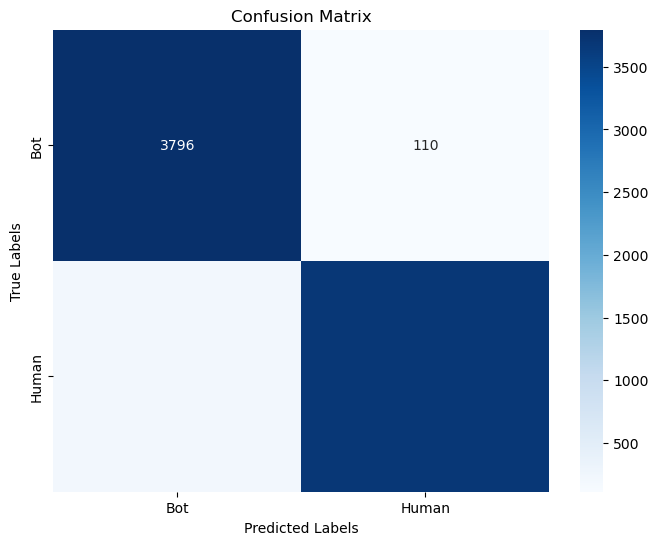

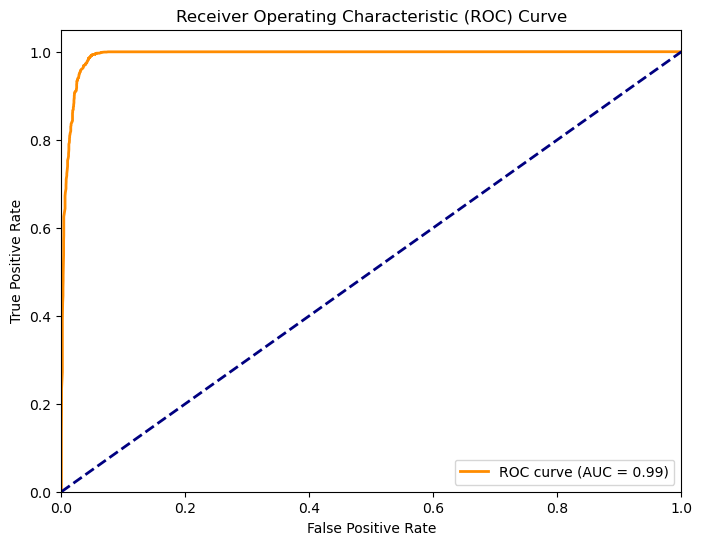

In [17]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://huggingface.co/datasets/airt-ml/twitter-human-bots/resolve/main/twitter_human_bots_dataset.csv"

print("Downloading the dataset...")
response = requests.get(url)
with open("twitter_human_bots_dataset.csv", "wb") as f:
    f.write(response.content)
print("Dataset downloaded successfully.")

print("Loading the dataset into a DataFrame...")
df = pd.read_csv("twitter_human_bots_dataset.csv")
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

print("Starting data preprocessing...")

df = df.dropna().reset_index(drop=True)
print(f"After dropping missing values: {df.shape[0]} rows remaining.\n")

le = LabelEncoder()
df['account_type_encoded'] = le.fit_transform(df['account_type'])
print("Encoded 'account_type' into 'account_type_encoded'.")

boolean_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in boolean_cols:
    df[col] = df[col].astype(int)
print("Converted boolean columns to integers.")

df['lang_encoded'] = le.fit_transform(df['lang'])
print("Encoded 'lang' into 'lang_encoded'.\n")

columns_to_drop = [
    'Unnamed: 0', 
    'created_at', 
    'id', 
    'profile_background_image_url', 
    'profile_image_url', 
    'screen_name', 
    'location', 
    'account_type', 
    'lang',
    'description'  
]
df_model = df.drop(columns=columns_to_drop)
print(f"Dropped columns: {columns_to_drop}\n")

print("Selecting features for modeling...")

X = df_model.drop('account_type_encoded', axis=1).copy()
y = df_model['account_type_encoded'].values
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}\n")

print("Balancing the dataset through oversampling...")

df_features = X.copy()
df_features['account_type_encoded'] = y

df_majority = df_features[df_features['account_type_encoded'] == 1]  
df_minority = df_features[df_features['account_type_encoded'] == 0]  

print(f"Number of human accounts (majority class): {df_majority.shape[0]}")
print(f"Number of bot accounts (minority class): {df_minority.shape[0]}\n")

df_minority_oversampled = resample(
    df_minority, 
    replace=True, 
    n_samples=len(df_majority), 
    random_state=42
)
print(f"Oversampled minority class to {len(df_minority_oversampled)} samples.\n")

df_balanced = pd.concat([df_majority, df_minority_oversampled])
print(f"Balanced dataset shape: {df_balanced.shape}\n")

X_balanced = df_balanced.drop('account_type_encoded', axis=1).values
y_balanced = df_balanced['account_type_encoded'].values

print("Performing train-test split while retaining 'account_age_days' for analysis...")



feature_names = X.columns.tolist()
if 'account_age_days' not in feature_names:
    raise ValueError("'account_age_days' not found in the feature set.")

age_index = feature_names.index('account_age_days')


X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, 
    y_balanced, 
    test_size=0.2, 
    stratify=y_balanced, 
    random_state=42
)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}\n")


X_train_age = X_train[:, age_index]
X_test_age = X_test[:, age_index]


X_train_features = np.delete(X_train, age_index, axis=1)
X_test_features = np.delete(X_test, age_index, axis=1)
print(f"Training features shape (without 'account_age_days'): {X_train_features.shape}")
print(f"Testing features shape (without 'account_age_days'): {X_test_features.shape}\n")





print("Applying feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)
print("Feature scaling complete.\n")





print("Training the Random Forest Classifier...")
rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=None,
    class_weight=None,
    bootstrap=False,
    random_state=42
)
rf.fit(X_train_scaled, y_train)
print("Model training complete.\n")





print("Evaluating the model...")


y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]


print("Classification Report:")
print(classification_report(y_test, y_pred))


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(
    fpr, 
    tpr, 
    color='darkorange', 
    lw=2, 
    label=f'ROC curve (AUC = {roc_auc:.2f})'
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Analyzing feature importances...

Top 10 Feature Importances:
                  Feature  Importance
3         followers_count    0.217350
2        favourites_count    0.204686
4           friends_count    0.186487
8  average_tweets_per_day    0.124412
6          statuses_count    0.121578
7                verified    0.066954
9            lang_encoded    0.036709
5             geo_enabled    0.030054
0         default_profile    0.011468
1   default_profile_image    0.000302


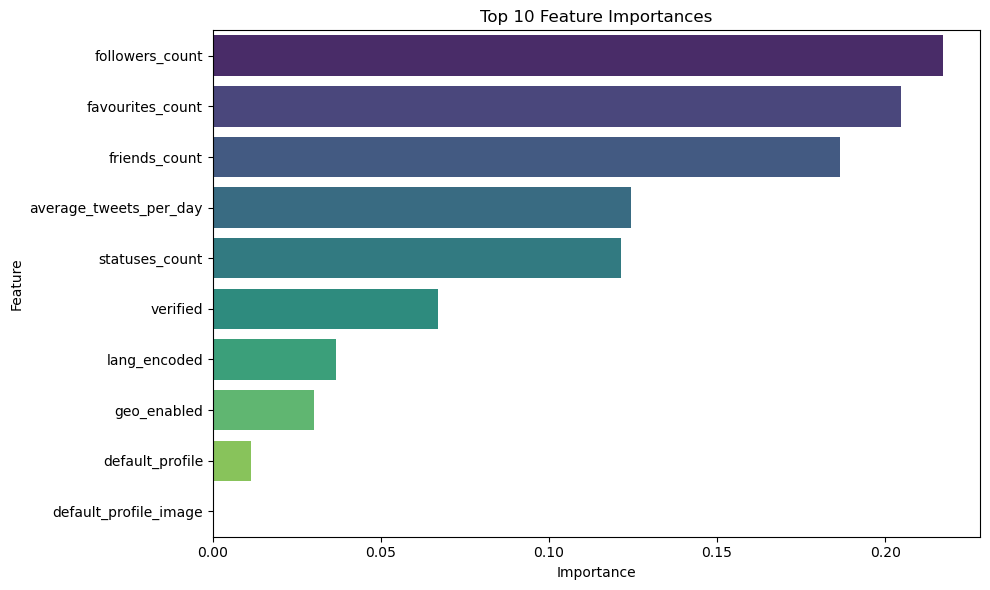

In [18]:





print("Analyzing feature importances...")


feature_names_no_age = [name for name in feature_names if name != 'account_age_days']


feature_importance = rf.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': feature_names_no_age,
    'Importance': feature_importance
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


top_features = feature_importance_df.head(10)


print("\nTop 10 Feature Importances:")
print(top_features)


plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_features, 
    palette='viridis', 
    orient='h'
)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Analyzing misclassifications by account age...

Misclassification Rates by Account Age:
      age_range  False Positives (Human as Bot) (%)  \
0     (0, 1000]                            2.941176   
1  (1000, 2000]                            8.510638   
2  (2000, 3000]                            7.270408   
3  (3000, 4000]                            5.606901   
4  (4000, 5000]                            3.585982   
5  (5000, 6000]                            0.000000   

   False Negatives (Bot as Human) (%)  
0                            0.000000  
1                            2.474227  
2                            1.811321  
3                            3.637524  
4                            3.671706  
5                            0.000000  


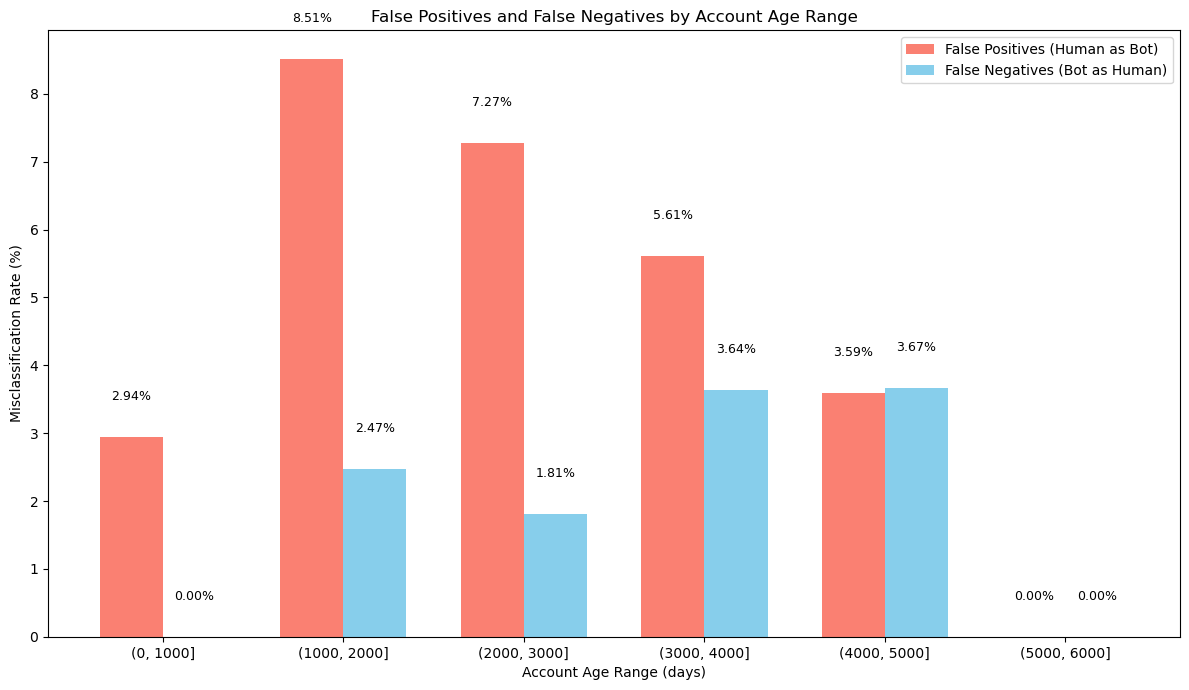

In [19]:





print("Analyzing misclassifications by account age...")


test_df = pd.DataFrame({
    'account_age_days': X_test_age,
    'true_label': y_test,
    'predicted_label': y_pred
})


bins = [0, 1000, 2000, 3000, 4000, 5000, 6000]
labels = ['(0, 1000]', '(1000, 2000]', '(2000, 3000]', '(3000, 4000]', '(4000, 5000]', '(5000, 6000]']
test_df['age_range'] = pd.cut(
    test_df['account_age_days'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)


age_ranges = []
false_positives = []
false_negatives = []


for label in labels:
    bin_df = test_df[test_df['age_range'] == label]
    total_humans = len(bin_df[bin_df['true_label'] == 1])
    total_bots = len(bin_df[bin_df['true_label'] == 0])
    
    
    fp = len(bin_df[(bin_df['true_label'] == 1) & (bin_df['predicted_label'] == 0)])
    
    fn = len(bin_df[(bin_df['true_label'] == 0) & (bin_df['predicted_label'] == 1)])
    
    
    fp_percent = (fp / total_humans * 100) if total_humans > 0 else 0
    fn_percent = (fn / total_bots * 100) if total_bots > 0 else 0
    
    age_ranges.append(label)
    false_positives.append(fp_percent)
    false_negatives.append(fn_percent)


summary_df = pd.DataFrame({
    'age_range': age_ranges,
    'False Positives (Human as Bot) (%)': false_positives,
    'False Negatives (Bot as Human) (%)': false_negatives
})

print("\nMisclassification Rates by Account Age:")
print(summary_df)


fig, ax = plt.subplots(figsize=(12, 7))


x = np.arange(len(labels))
width = 0.35


ax.bar(
    x - width/2, 
    false_positives, 
    width, 
    label='False Positives (Human as Bot)', 
    color='salmon'
)
ax.bar(
    x + width/2, 
    false_negatives, 
    width, 
    label='False Negatives (Bot as Human)', 
    color='skyblue'
)


ax.set_xlabel('Account Age Range (days)')
ax.set_ylabel('Misclassification Rate (%)')
ax.set_title('False Positives and False Negatives by Account Age Range')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


for i in range(len(labels)):
    ax.text(
        x[i] - width/2, 
        false_positives[i] + 0.5, 
        f"{false_positives[i]:.2f}%", 
        ha='center', 
        va='bottom', 
        fontsize=9
    )
    ax.text(
        x[i] + width/2, 
        false_negatives[i] + 0.5, 
        f"{false_negatives[i]:.2f}%", 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

plt.tight_layout()
plt.show()


/Users/kylehe/miniconda3/envs/cs360-lab1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kylehe/miniconda3/envs/cs360-lab1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kylehe/miniconda3/envs/cs360-lab1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kylehe/miniconda3/envs/cs360-lab1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

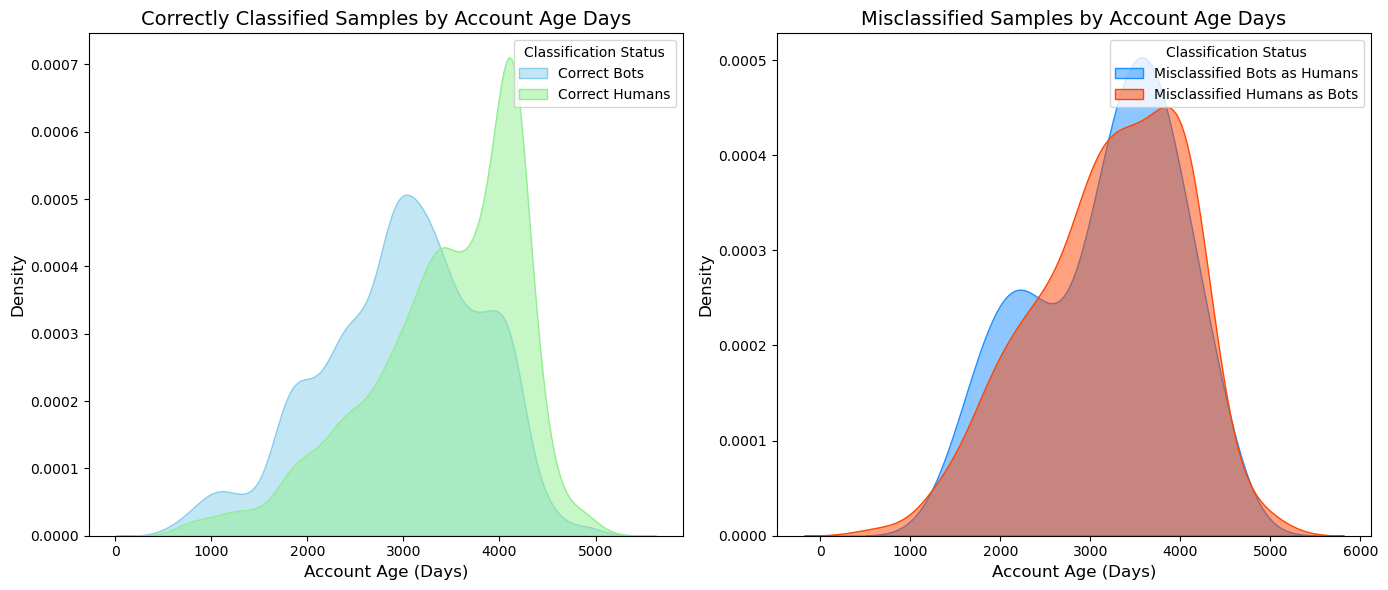

In [21]:




import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


required_columns = {'account_age_days', 'true_label', 'predicted_label'}
missing_columns = required_columns - set(test_df.columns)
if missing_columns:
    raise ValueError(f"DataFrame 'test_df' is missing the columns: {missing_columns}")


test_df['classification_status'] = np.where(
    test_df['true_label'] == test_df['predicted_label'], 
    'Correct', 
    'Misclassified'
)


test_df['true_label'] = test_df['true_label'].map({0: 'Bot', 1: 'Human'})
test_df['predicted_label'] = test_df['predicted_label'].map({0: 'Bot', 1: 'Human'})


comparison_df = test_df.copy()


plt.figure(figsize=(14, 6))




plt.subplot(1, 2, 1)
sns.kdeplot(
    data=comparison_df[
        (comparison_df['classification_status'] == 'Correct') & 
        (comparison_df['true_label'] == 'Bot')
    ],
    x='account_age_days', 
    fill=True, 
    color='skyblue', 
    alpha=0.5, 
    label='Correct Bots'
)
sns.kdeplot(
    data=comparison_df[
        (comparison_df['classification_status'] == 'Correct') & 
        (comparison_df['true_label'] == 'Human')
    ],
    x='account_age_days', 
    fill=True, 
    color='lightgreen', 
    alpha=0.5, 
    label='Correct Humans'
)
plt.title('Correctly Classified Samples by Account Age Days', fontsize=14)
plt.xlabel('Account Age (Days)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title="Classification Status", loc='upper right')




plt.subplot(1, 2, 2)
sns.kdeplot(
    data=comparison_df[
        (comparison_df['classification_status'] == 'Misclassified') & 
        (comparison_df['true_label'] == 'Bot')
    ],
    x='account_age_days', 
    fill=True, 
    color='dodgerblue', 
    alpha=0.5, 
    label='Misclassified Bots as Humans'
)
sns.kdeplot(
    data=comparison_df[
        (comparison_df['classification_status'] == 'Misclassified') & 
        (comparison_df['true_label'] == 'Human')
    ],
    x='account_age_days', 
    fill=True, 
    color='orangered', 
    alpha=0.5, 
    label='Misclassified Humans as Bots'
)
plt.title('Misclassified Samples by Account Age Days', fontsize=14)
plt.xlabel('Account Age (Days)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title="Classification Status", loc='upper right')


plt.tight_layout()


plt.show()
